### Imports

In [3]:
# general imports 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
sns.set()

# model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# utils
from utils import *

In [4]:
df_train = pd.read_csv("train.csv")
df_valid = pd.read_csv("valid.csv")
df_test = pd.read_csv("test.csv")

X_train, y_train, X_valid, y_valid, X_test, y_test = with_resampling(df_train, df_valid, df_test)

In [5]:
clf1 = KNeighborsClassifier(leaf_size=49, n_neighbors=25, p=1)
clf2 = DecisionTreeClassifier(max_depth=6, min_samples_split=2, min_samples_leaf=13,class_weight={0:0.0053, 1: 0.9947})
clf3 = GaussianNB()
clf4 = LogisticRegression(max_iter=1000)
clf5 = LGBMClassifier(lambda_l1 = 2.86e-05,lambda_l2 = 0.754, num_leaves=72, feature_selection = 0.842, bagging_fraction = 0.714, bagging_freq = 2)
clf6 = XGBClassifier( gamma = 0.953, min_child_weight =5, max_depth = 7, eta = 0.2, grow_policy = 'depthwise',n_estimators = 842)
eclf1 = VotingClassifier(estimators=[
        ('knn', clf1), ('dt', clf2), ('gnb', clf3), ('lr', clf4), ('xgb', clf6)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)

### Validation Performance

In [6]:
y_pred = eclf1.predict(X_valid)
get_scores(y_valid, y_pred)

Precision: 0.097
Accuracy: 0.661
Recall: 0.567
F1: 0.165
Fbeta: 0.287
ROC AUC: 0.617
PR AUC: 0.080


<AxesSubplot:title={'center':'Performance on validation set'}, xlabel='Predictions', ylabel='True Labels'>

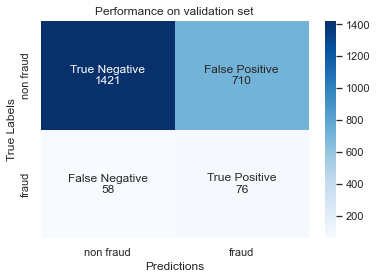

In [7]:
get_confusion_matrix(y_valid, y_pred, "Performance on validation set")

### SHAP

In [11]:
import shap
# Fits the explainer
explainer = shap.Explainer(eclf1.predict, X_train, seed=0)
shap_values = explainer(X_train[1:100,:])

Permutation explainer: 100it [11:36,  7.10s/it]                       


In [12]:
#creating a feature list
features  = df_train.drop('FraudFound_P', axis=1).columns.tolist()

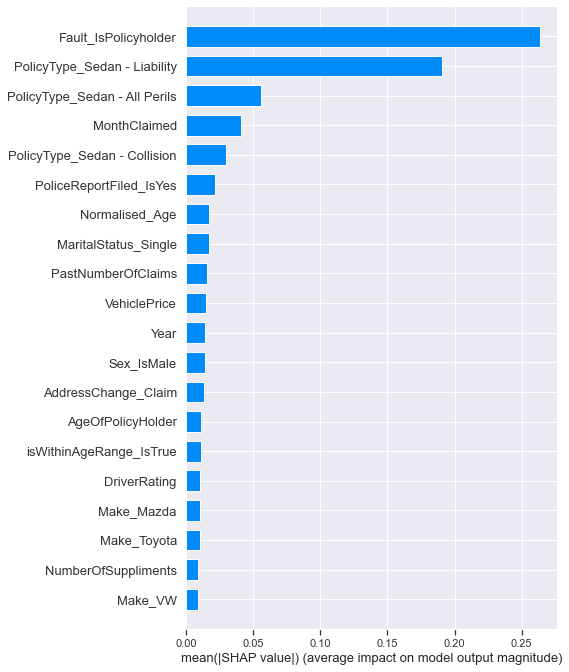

In [13]:
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=features)

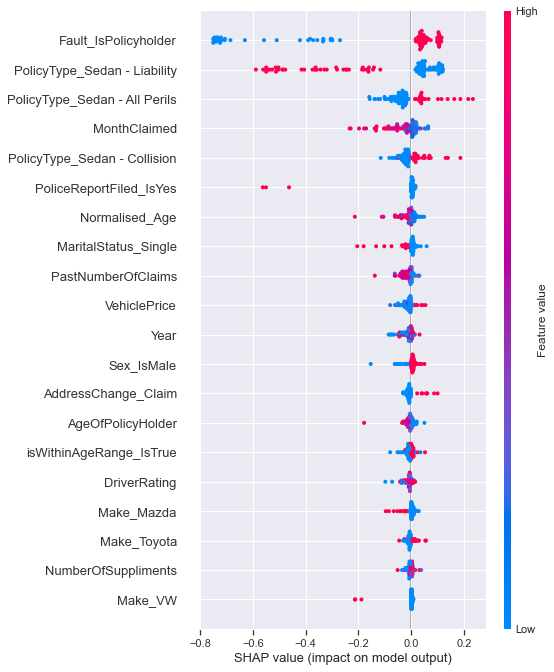

In [15]:
shap.summary_plot(shap_values, X_train[1:100,:],features)

### Test Performance

In [8]:
y_pred = eclf1.predict(X_test)
get_scores(y_valid, y_pred)

Precision: 0.053
Accuracy: 0.655
Recall: 0.284
F1: 0.089
Fbeta: 0.151
ROC AUC: 0.481
PR AUC: 0.057


<AxesSubplot:title={'center':'Performance on test set'}, xlabel='Predictions', ylabel='True Labels'>

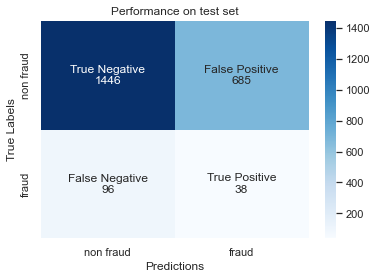

In [9]:
get_confusion_matrix(y_valid, y_pred, "Performance on test set")